# Tutorial 5 - Training Spiking Neural Networks with snnTorch

## Learn how to
- implement spiking neurons as a recurrent network
- understand backpropagation through time, and the associated challenges in SNNs such as the non-differentiability of spikes
- train a FC network on the static MNIST dataset

> Spiking neuron을 사용하여 네트워크를 구현하고, backpropagation과 실제 데이터 학습에 대해 알아본다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import spikegen
from snntorch import spikeplot as splt

# 1. A Recurrent representation of SNNs

이제껏 다룬 SNN은 이산 시간에서 다뤄졌고, 이전 출력의 영향을 받는다. 전체적인 computational graph를 그려보면 아래와 같다.

![unrolled2](./images/unrolled_2.png)

> $U[t+1]=\underbrace{\beta U[t]}_{decay}+\underbrace{I_{syn}[t+1]}_{Input}-\underbrace{R[t]}_{reset}$
>
> $S[t]=\left\{\begin{matrix} 1,\ if U(t) > U_{thr} \\ 0,\ \ \ \ \ \ \ otherwise \end{matrix}\right.$

# 2. The Non-Differentiability of spikes

## 2.1 Training using the Backprop algorithm

위 식에서 *Reset* 텀의 $S[t]$ 는 다음과 같이 *Unit step function* 으로 표현할 수 있다.

> $S[t]=\Theta(U[t]-U_{thr})$

이와 같은 *step function* 은 backprop 과정에서 아래와 같이 미분이 불가능해지는 문제를 발생시킨다.

![non-diff](./images/non-diff.png)

> $\frac{\partial L}{\partial W}=\frac{\partial L}{\partial S}\underbrace{\frac{\partial S}{\partial U}}_{\{0,\infty\}}\frac{\partial U}{\partial I}\frac{\partial I}{\partial W}$

위와 같은 chain rule로 인해 대부분의 경우 gradient가 0이 되고, $U_{thr}=0$ 인 경우에는 무한대가 된다. 기울기가 거의 항상 0으로 유지되면(U가 정확히 threshold에 위치할 때는 무한대로 발산) 어떠한 학습도 일어날 수 없고, 이는 **Dead Neuron Problem** 으로 알려져있다.

## 2.2 Overcome the Dead Neuron Problem

위와 같은 Dead Neuron Problem을 방지하기 위해서 $\frac{\partial S}{\partial U}$ 텀을 역전파가 이어질 수 있도록 임의의 $\frac{\partial \tilde{S}}{\partial U}$ 로 변경한다. 이러한 근사치는 꽤나 강인한 방법으로 알려져 있고, 이를 **Surrogate Gradient** approach 라고 한다.

이번 튜토리얼에서는 간단하게 하기 위해, $\frac{\partial \tilde{S}}{\partial U}=S$ 로 정의한다. 이전 뉴런이 활성화 됐었을 때는 1, 아닌 경우는 0으로 한다.

> $\frac{\partial \tilde{S}}{\partial U}\leftarrow S=\left\{\begin{matrix} 1,\ if\ U>U_{thr}\\0,\ \ \ \ otherwise \end{matrix}\right.$

In [2]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach()  # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset  # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad

In [3]:
lif1 = LeakySurrogate(beta=0.9)

snnTorch 에서는 위와 같은 역전파를 위한 *spike operator*가 모든 뉴런 모델 함수에 내장되어 있기 때문에, default로 사용하여도 문제가 없을 것이다.

In [4]:
lif1 = snn.Leaky(beta=0.9)

# 3. Backpropagation through time

> $\frac{\partial L}{\partial W}=\frac{\partial L}{\partial S}\underbrace{\frac{\partial S}{\partial U}}_{\{0,\infty\}}\frac{\partial U}{\partial I}\frac{\partial I}{\partial W}$

위 식은 단일 time-step 에서의 전개이다. 실제로는 모든 time-step에 걸쳐 해당 과정이 수행되어야 한다. 매 시간에서의 가중치에 의한 Loss의 기울기는 다음과 같이 적을 수 있을 것이다.

> $\frac{\partial L}{\partial W}=\sum_{t}\frac{\partial L[t]}{\partial W}=\sum_{t}\sum_{s\leq t}\frac{\partial L[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W}$

이때, recurrent system에서 $W[s]$는 모든 $W$에 대해서 동일한 효과를 가진다. 즉, $\frac{\partial W[s]}{\partial W}=1$ 이라고 할 수 있다. 이제 위 식을 다시 쓰면 아래와 같다.

> $\frac{\partial L}{\partial W}=\sum_{t}\sum_{s\leq t}\frac{\partial L[t]}{\partial W[s]}$

전체적인 backprop 과정을 도식화하면 아래와 같다.

![bptt](./images/bptt.png)

# 4. Setting up the loss & output decoding

Classification 문제에서 SNN의 출력 spike를 해석하는 방식은 몇 가지가 있지만 가장 일반적인 것은 아래 두 가지이다.

> **Rate coding**: 가장 많이 활성화된 뉴런
>
> **Latency coding**: 가장 먼저 활성화된 뉴런
>
> 을 예측 class로 한다.

여기서는 **rate code** 방식을 사용한다. 출력 뉴런의 membrane potential에 대해서 softmax 함수를 적용하면 

> $p_i[t]=\frac{e^{U_i[t]}}{\sum_{i=0}^{C}e^{U_i[t]}}$

이렇게 나온 $p_i[t]$ 에 대해서 *cross-entropy error* 를 사용한다. 여기서 $C$ 는 전체 클래스의 개수이다.

> $L_{CE}[t]=\sum_{i=0}^Cy_ilog(p_i[t])$

전체 time-step에 대해서 최종 loss는 아래와 같다고 할 수 있다.

> $L_{CE}=\sum_tL_{CE}[t]$

이와 같은 방식은 한 예시일 뿐이고, *snn.functional* 을 통해 다양한 접근법을 사용할 수 있다.

# 5. Setting up the static MNIST dataset

In [5]:
# Dataloader arguments
batch_size = 128
data_path  = './data'

dtype  = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)), 
            transforms.Grayscale(), 
            transforms.ToTensor(), 
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. Define the network

In [6]:
# Network Architecture
num_inputs  = 28*28     # size of MNIST images
num_hidden  = 1000
num_outputs = 10        # num of MNIST classes

# Temporal dynamics
num_steps = 25
beta      = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        self.fc1  = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2  = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif1.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
# Load the network onto CUDA if available
net = Net().to(device)

# 7. Training the SNN

In [7]:
# Pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx    = output.sum(dim=0).max(1)
    acc       = np.mean((targets==idx).detach().cpu().numpy())
    
    if train:
        print(f'Train set accuracy for a single minibatch: {acc*100:.2f}%')
    else:
        print(f'Test set accuracy for a single minibatch: {acc*100:.2f}%')
        
def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [8]:
# Loss definition
loss = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# One iteration of training
data, targets = next(iter(train_loader))
data    = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


In [9]:
# Initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# Sum loss at every step
for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)
    
print(f'Traing loss: {loss_val.item():.3f}')
print_batch_accuracy(data, targets, train=True)

Traing loss: 60.147
Train set accuracy for a single minibatch: 7.81%


In [10]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)
  
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 51.282
Train set accuracy for a single minibatch: 54.69%


## Training Loop

In [12]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 51.63
Test Set Loss: 49.02
Train set accuracy for a single minibatch: 55.47%
Test set accuracy for a single minibatch: 50.00%


Epoch 0, Iteration 50
Train Set Loss: 11.03
Test Set Loss: 14.26
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 12.94
Test Set Loss: 10.56
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 150
Train Set Loss: 7.71
Test Set Loss: 9.82
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 200
Train Set Loss: 6.34
Test Set Loss: 9.00
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 250
Train Set Loss: 10.51
Test Set Loss: 5.11
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 98.44%


Epoch 

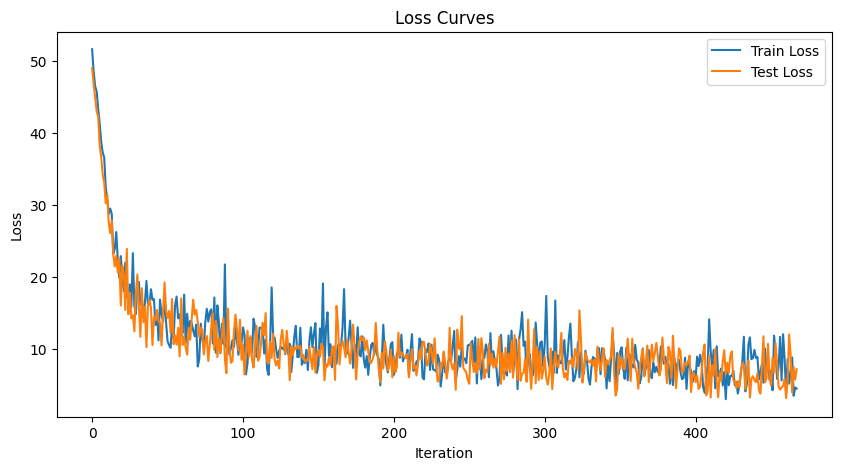

In [13]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Test set accuracy

In [14]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [15]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9346/10000
Test Set Accuracy: 93.46%
